## 1. Setup and Load Previous Results

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.sparse import load_npz, csr_matrix
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [22]:
# Load features
features_dir = './features'

print("=" * 60)
print("LOADING FEATURES")
print("=" * 60)

user_item_matrix = load_npz(f'{features_dir}/user_item_matrix.npz')
bundle_game_matrix = load_npz(f'{features_dir}/bundle_game_matrix.npz')
game_similarity_bundle = load_npz(f'{features_dir}/game_similarity_bundle.npz')
game_similarity_copurchase = load_npz(f'{features_dir}/game_similarity_copurchase.npz')
game_similarity_combined = load_npz(f'{features_dir}/game_similarity_combined.npz')
bundle_similarity_matrix = np.load(f'{features_dir}/bundle_similarity_matrix.npy')

with open(f'{features_dir}/mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
    user_to_idx = mappings['user_to_idx']
    idx_to_user = mappings['idx_to_user']
    item_to_idx = mappings['item_to_idx']
    idx_to_item = mappings['idx_to_item']
    bundle_to_idx = mappings['bundle_to_idx']
    idx_to_bundle = mappings['idx_to_bundle']

game_popularity_df = pd.read_csv(f'{features_dir}/game_popularity.csv')
popularity_scores = game_popularity_df.sort_values('item_idx')['popularity_score'].values

print(f"✓ Loaded all features")
print(f"  Users: {user_item_matrix.shape[0]:,}")
print(f"  Games: {user_item_matrix.shape[1]:,}")
print(f"  Bundles: {bundle_game_matrix.shape[0]:,}")

LOADING FEATURES
✓ Loaded all features
  Users: 70,912
  Games: 10,978
  Bundles: 613
✓ Loaded all features
  Users: 70,912
  Games: 10,978
  Bundles: 613


In [23]:
# Load train/test split from previous run
train_matrix = load_npz('./model_outputs/train_matrix.npz')
test_df = pd.read_csv('./model_outputs/test_set.csv')

print(f"✓ Loaded train/test split")
print(f"  Train: {train_matrix.nnz:,} interactions")
print(f"  Test: {len(test_df):,} interactions")
print(f"  Test users: {test_df['user_idx'].nunique():,}")

✓ Loaded train/test split
  Train: 4,103,384 interactions
  Test: 990,698 interactions
  Test users: 62,936


In [24]:
# After cell #VSC-39c9f8f5

# Verify test_df schema
print("=" * 60)
print("SCHEMA VALIDATION")
print("=" * 60)
print("Columns in test_df:", test_df.columns.tolist())
print("Sample rows:")
print(test_df.head())

# Check which ID column exists
has_item_idx = 'item_idx' in test_df.columns
has_item_id = 'item_id' in test_df.columns

print(f"\n✓ Has 'item_idx': {has_item_idx}")
print(f"✓ Has 'item_id': {has_item_id}")

if has_item_idx and not has_item_id:
    print("\n⚠️  WARNING: test_df has 'item_idx' but NOT 'item_id'")
    print("Creating 'item_id' column by mapping item_idx -> game_id...")
    test_df['item_id'] = test_df['item_idx'].map(lambda x: idx_to_item.get(x, -1))
    print(f"✓ Created item_id column with {test_df['item_id'].nunique()} unique IDs")
elif has_item_id and not has_item_idx:
    print("\n⚠️  WARNING: test_df has 'item_id' but NOT 'item_idx'")
    print("Creating 'item_idx' column by mapping item_id -> idx...")
    test_df['item_idx'] = test_df['item_id'].map(lambda x: item_to_idx.get(x, -1))
    print(f"✓ Created item_idx column")

print("\nFinal columns:", test_df.columns.tolist())

SCHEMA VALIDATION
Columns in test_df: ['user_idx', 'item_idx', 'user_id', 'item_id']
Sample rows:
   user_idx  item_idx  user_id  item_id
0         0        47  --000--   104700
1         0       415  --000--   200210
2         0      3279  --000--   302830
3         0      1003  --000--   223530
4         0      4964  --000--   346900

✓ Has 'item_idx': True
✓ Has 'item_id': True

Final columns: ['user_idx', 'item_idx', 'user_id', 'item_id']


## 2. Load Model Classes

In [25]:
import numpy as np
import torch

class NextGameRecommender:
    """
    Hybrid recommender combining:
    1. Item-based collaborative filtering
    2. Bundle-enhanced similarity
    3. Popularity baseline
    """

    def __init__(self, train_matrix, similarity_matrix, popularity_scores, alpha=0.7,
                 device=None, densify_similarity_auto_cap_bytes=1_000_000_000):
        self.train_matrix = train_matrix
        self.similarity_matrix = similarity_matrix
        self.alpha = alpha

        self.device = torch.device(device) if device is not None else (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )
        print("Device:", self.device)
        
        # Popularity on GPU
        pop = torch.as_tensor(popularity_scores, dtype=torch.float32)
        self.popularity_t = pop.flatten().to(self.device)
        self.n_items = int(self.popularity_t.numel())

        # Try to keep a GPU dense similarity matrix when feasible
        self.similarity_t = None
        if torch.is_tensor(similarity_matrix):
            self.similarity_t = similarity_matrix.to(self.device, dtype=torch.float32)
        elif isinstance(similarity_matrix, np.ndarray):
            self.similarity_t = torch.from_numpy(similarity_matrix).to(self.device, dtype=torch.float32)
        else:
            shape = getattr(similarity_matrix, "shape", None)
            if shape is not None and len(shape) == 2 and shape[0] == shape[1]:
                est_bytes = int(shape[0]) * int(shape[1]) * 4
                if self.device.type == "cuda" and est_bytes <= densify_similarity_auto_cap_bytes:
                    dense = similarity_matrix.toarray() if hasattr(similarity_matrix, "toarray") else np.asarray(similarity_matrix)
                    self.similarity_t = torch.from_numpy(dense).to(self.device, dtype=torch.float32)

    def recommend(self, user_idx, k=10, exclude_owned=True):
        k = int(min(k, self.n_items))
        user_items = self.train_matrix[user_idx].nonzero()[1]

        if len(user_items) == 0:
            top_vals, top_idx = torch.topk(self.popularity_t, k)
            return [(int(i), float(v)) for i, v in zip(top_idx.tolist(), top_vals.tolist())]

        if self.similarity_t is not None:
            user_items_t = torch.tensor(user_items, device=self.device, dtype=torch.long)
            scores_t = self.similarity_t.index_select(0, user_items_t).sum(dim=0)
            scores_t = scores_t / float(len(user_items))
        else:
            user_profile = self.train_matrix[user_idx].copy()
            user_profile.data = np.ones_like(user_profile.data)
            cpu_scores = user_profile.dot(self.similarity_matrix)
            if hasattr(cpu_scores, "toarray"):
                scores_np = cpu_scores.toarray().ravel()
            else:
                scores_np = np.asarray(cpu_scores).ravel()
            scores_np = scores_np / float(len(user_items))
            scores_t = torch.from_numpy(scores_np).to(self.device, dtype=torch.float32)

        combined_scores_t = self.alpha * scores_t + (1 - self.alpha) * self.popularity_t

        if exclude_owned:
            user_items_t = torch.tensor(user_items, device=self.device, dtype=torch.long)
            combined_scores_t.index_fill_(0, user_items_t, float("-inf"))

        top_vals, top_idx = torch.topk(combined_scores_t, k)
        return [(int(i), float(v)) for i, v in zip(top_idx.tolist(), top_vals.tolist())]


import numpy as np
from collections import defaultdict
from scipy import sparse  # you’re already using sparse matrices, so this should be available

# Replace cell #VSC-11986efc (BundleCompletionRecommender class)

class BundleCompletionRecommender:
    def __init__(self, user_item_matrix, bundle_game_matrix, idx_to_item, item_to_idx):
        self.user_item_matrix = user_item_matrix.tocsr()
        self.bundle_game_matrix = bundle_game_matrix.tocsr()
        self.item_to_idx = item_to_idx  # ADD THIS

        n_items = self.user_item_matrix.shape[1]

        # Store both mappings
        if isinstance(idx_to_item, dict):
            arr = np.full(n_items, -1, dtype=np.int64)
            for i, v in idx_to_item.items():
                arr[int(i)] = int(v)
            self.idx_to_item = arr
        else:
            self.idx_to_item = np.asarray(idx_to_item).astype(np.int64, copy=False)

        self.bundle_sizes = np.asarray(self.bundle_game_matrix.getnnz(axis=1)).ravel()
        self.bundle_items = [self.bundle_game_matrix[i].indices for i in range(self.bundle_game_matrix.shape[0])]
        self.n_items = n_items

    def recommend(self, user_idx, k=10, min_ownership=0.3, return_indices=True):
        """
        Args:
            return_indices: If True, return item_idx (for evaluation). 
                          If False, return item_id (for display).
        """
        owned = self.user_item_matrix[user_idx].indices
        if owned.size == 0:
            return []

        user_vec = sparse.csr_matrix(
            (np.ones_like(owned, dtype=np.float32), (np.zeros_like(owned), owned)),
            shape=(1, self.n_items)
        )

        overlap = (self.bundle_game_matrix @ user_vec.T).toarray().ravel()
        sizes = self.bundle_sizes

        partial_mask = (overlap > 0) & (overlap < sizes)
        if not np.any(partial_mask):
            return []

        partial_idx = np.where(partial_mask)[0]
        ownership_ratio = overlap[partial_idx] / sizes[partial_idx]

        keep = ownership_ratio >= float(min_ownership)
        partial_idx = partial_idx[keep]
        ownership_ratio = ownership_ratio[keep]
        if partial_idx.size == 0:
            return []

        owned_set = set(map(int, owned))
        scores = {}

        for b, r in zip(partial_idx, ownership_ratio):
            for item_i in self.bundle_items[int(b)]:
                item_i = int(item_i)
                if item_i not in owned_set:
                    # Store by item_idx (matrix position)
                    prev = scores.get(item_i)
                    if prev is None or r > prev:
                        scores[item_i] = float(r)

        # Sort by score
        sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]
        
        # Convert to game_id if requested
        if not return_indices:
            return [(int(self.idx_to_item[item_idx]), score) 
                    for item_idx, score in sorted_items]
        
        return sorted_items  # Return (item_idx, score)

In [26]:
# Replace cell #VSC-134d3b86

bundle_recommender = BundleCompletionRecommender(
    train_matrix,
    bundle_game_matrix,
    idx_to_item,
    item_to_idx  # ADD THIS
)

In [27]:
print("idx_to_item dtype:", bundle_recommender.idx_to_item.dtype)
print("idx_to_item sample:", bundle_recommender.idx_to_item[:5].tolist())

u = int(test_df["user_idx"].iloc[0])
recs = bundle_recommender.recommend(u, k=10, min_ownership=0.3)
rec_ids = [x[0] for x in recs] if recs else []
actual_ids = test_df[test_df["user_idx"] == u]["item_id"].tolist()

print("sample rec ids:", rec_ids[:5], "type:", type(rec_ids[0]) if rec_ids else None)
print("sample actual ids:", actual_ids[:5], "type:", type(actual_ids[0]) if actual_ids else None)
print("intersection size:", len(set(rec_ids) & set(actual_ids)))


idx_to_item dtype: int64
idx_to_item sample: [10, 100, 10000, 1002, 10040]
sample rec ids: [10158, 1385, 1882, 3399, 1629] type: <class 'int'>
sample actual ids: [104700, 200210, 302830, 223530, 346900] type: <class 'int'>
intersection size: 0


## 3. Task 2: Quantitative Evaluation - Bundle Completion

We'll evaluate:
1. **Completion Accuracy**: How many recommended games were actually purchased?
2. **Bundle-specific Precision**: Do recommendations help complete bundles?
3. **Ownership Ratio Analysis**: At what % ownership are recommendations most accurate?

In [ ]:
# Replace cell #VSC-3e0bbb4f

def evaluate_bundle_completion(recommender, test_df, train_matrix, k_values=[5, 10, 20], min_ownership=0.3):
    print(f"\nEvaluating Bundle Completion Recommender...")

    # USE item_idx (matrix indices) for evaluation
    actual_by_user = test_df.groupby('user_idx')['item_idx'].apply(list).to_dict()
    test_users = list(actual_by_user.keys())

    B = recommender.bundle_game_matrix
    bundle_sizes = recommender.bundle_sizes
    bundle_items = recommender.bundle_items

    results = {
        k: {'precision': [], 'recall': [], 'hit_rate': [], 'bundle_precision': [], 'ownership_ratios': []}
        for k in k_values
    }

    users_with_partial_bundles = 0
    max_k = max(k_values)
    n_items = train_matrix.shape[1]

    for i, user_idx in enumerate(test_users):
        if i % 5000 == 0:
            print(f"  Progress: {i}/{len(test_users)} users...")

        row = train_matrix[user_idx]
        owned = row.indices if hasattr(row, "indices") else row.nonzero()[1]
        if len(owned) == 0:
            continue

        user_vec = sparse.csr_matrix(
            (np.ones_like(owned, dtype=np.float32), (np.zeros_like(owned), owned)),
            shape=(1, n_items)
        )

        overlap = (B @ user_vec.T).toarray().ravel()
        partial_mask = (overlap > 0) & (overlap < bundle_sizes)
        if not np.any(partial_mask):
            continue

        partial_idx = np.where(partial_mask)[0]
        ratios = overlap[partial_idx] / bundle_sizes[partial_idx]

        keep = ratios >= float(min_ownership)
        partial_idx = partial_idx[keep]
        ratios = ratios[keep]
        if partial_idx.size == 0:
            continue

        users_with_partial_bundles += 1

        owned_set = set(map(int, owned))
        all_missing_games = set()
        for b in partial_idx:
            for it in bundle_items[int(b)]:
                it = int(it)
                if it not in owned_set:
                    all_missing_games.add(it)  # Keep as item_idx

        max_ratio = float(ratios.max()) if ratios.size else 0.0

        # Get recommendations as item_idx
        recs = recommender.recommend(user_idx, k=max_k, min_ownership=min_ownership, return_indices=True)
        if not recs:
            continue

        rec_item_indices = [int(item_idx) for item_idx, _ in recs]
        actual_set = set(actual_by_user.get(user_idx, []))

        for k in k_values:
            rec_set = set(rec_item_indices[:k])

            hits = len(actual_set & rec_set)
            precision = hits / k if k > 0 else 0.0
            recall = hits / len(actual_set) if len(actual_set) > 0 else 0.0
            hit_rate = 1.0 if hits > 0 else 0.0

            results[k]['precision'].append(precision)
            results[k]['recall'].append(recall)
            results[k]['hit_rate'].append(hit_rate)

            bundle_hits = len(rec_set & all_missing_games)
            results[k]['bundle_precision'].append(bundle_hits / k if k > 0 else 0.0)
            results[k]['ownership_ratios'].append(max_ratio)

    summary = {}
    for k in k_values:
        summary[k] = {
            'precision': float(np.mean(results[k]['precision'])) if results[k]['precision'] else 0.0,
            'recall': float(np.mean(results[k]['recall'])) if results[k]['recall'] else 0.0,
            'hit_rate': float(np.mean(results[k]['hit_rate'])) if results[k]['hit_rate'] else 0.0,
            'bundle_precision': float(np.mean(results[k]['bundle_precision'])) if results[k]['bundle_precision'] else 0.0,
            'avg_ownership': float(np.mean(results[k]['ownership_ratios'])) if results[k]['ownership_ratios'] else 0.0
        }

    print(f"\n✓ Evaluated {users_with_partial_bundles:,} users with partial bundles")
    return summary

In [ ]:
# Initialize and evaluate Bundle Completion Recommender
print("=" * 60)
print("TASK 2: BUNDLE COMPLETION EVALUATION")
print("=" * 60)

# Replace cell #VSC-134d3b86

bundle_recommender = BundleCompletionRecommender(
    train_matrix,
    bundle_game_matrix,
    idx_to_item,
    item_to_idx  # ADD THIS
)

# --- DEBUG CHECKS (paste right after bundle_recommender is created) ---

# 1) Basic: types + sample values
print("test_df item_id dtype:", test_df["item_id"].dtype)
print("sample test item_id values:", test_df["item_id"].head(5).tolist())

# idx_to_item stored inside the recommender (we converted it to a numpy array)
print("idx_to_item type:", type(bundle_recommender.idx_to_item))
print("idx_to_item sample:", bundle_recommender.idx_to_item[:5].tolist())

# 2) Universe overlap: do train IDs and test IDs match at all?
train_ids = set(bundle_recommender.idx_to_item.tolist())
test_ids = set(test_df["item_id"].unique().tolist())

print("unique train ids:", len(train_ids))
print("unique test ids :", len(test_ids))
print("overlap count   :", len(train_ids & test_ids))

# 3) Per-user intersection sanity check
u = int(test_df["user_idx"].iloc[0])
recs = bundle_recommender.recommend(u, k=10, min_ownership=0.3)
rec_ids = [x[0] for x in recs] if recs else []
actual_ids = test_df[test_df["user_idx"] == u]["item_id"].tolist()

print("\nUser", u)
print("sample rec ids   :", rec_ids[:5], "type:", type(rec_ids[0]) if rec_ids else None)
print("sample actual ids:", actual_ids[:5], "type:", type(actual_ids[0]) if actual_ids else None)
print("intersection size:", len(set(rec_ids) & set(actual_ids)))

bundle_results = evaluate_bundle_completion(
    bundle_recommender, 
    test_df, 
    train_matrix,
    k_values=[5, 10, 20]
)

print("\n" + "=" * 60)
print("BUNDLE COMPLETION RESULTS")
print("=" * 60)
for k, metrics in bundle_results.items():
    print(f"\nK={k}:")
    print(f"  Precision@{k}: {metrics['precision']:.4f}")
    print(f"  Recall@{k}: {metrics['recall']:.4f}")
    print(f"  Hit Rate@{k}: {metrics['hit_rate']:.4f}")
    print(f"  Bundle Precision@{k}: {metrics['bundle_precision']:.4f} (% recs from partial bundles)")
    print(f"  Avg Ownership: {metrics['avg_ownership']:.2%}")

TASK 2: BUNDLE COMPLETION EVALUATION
test_df item_id dtype: int64
sample test item_id values: [104700, 200210, 302830, 223530, 346900]
idx_to_item type: <class 'numpy.ndarray'>
idx_to_item sample: [10, 100, 10000, 1002, 10040]
unique train ids: 10978
unique test ids : 9545
overlap count   : 9545

User 0
sample rec ids   : [500, 240, 257990, 307230, 249230] type: <class 'int'>
sample actual ids: [104700, 200210, 302830, 223530, 346900] type: <class 'int'>
intersection size: 0

Evaluating Bundle Completion Recommender...
  Progress: 0/62936 users...
  Progress: 5000/62936 users...
  Progress: 10000/62936 users...
  Progress: 15000/62936 users...
  Progress: 20000/62936 users...
  Progress: 25000/62936 users...
  Progress: 30000/62936 users...
  Progress: 35000/62936 users...
  Progress: 40000/62936 users...
  Progress: 45000/62936 users...
  Progress: 50000/62936 users...
  Progress: 55000/62936 users...
  Progress: 60000/62936 users...

✓ Evaluated 56,108 users with partial bundles

BUN

## 4. Task 3: Quantitative Evaluation - Cross-Bundle Discovery

We'll evaluate:
1. **Similarity Quality**: Average similarity scores
2. **Diversity**: Are recommended bundles diverse enough?
3. **User Overlap**: Do users who bought source bundle also buy similar bundles?

In [9]:
def evaluate_cross_bundle_discovery(recommender, bundle_game_matrix, user_item_matrix, k=5):
    """
    Evaluate cross-bundle recommendations
    """
    print(f"\nEvaluating Cross-Bundle Discovery...")
    
    n_bundles = bundle_game_matrix.shape[0]
    
    results = {
        'similarity_scores': [],
        'diversity_scores': [],      # Jaccard distance (1 - overlap)
        'user_overlap_scores': [],   # User base similarity
        'coverage': 0                # % bundles with recommendations
    }
    
    bundles_with_recommendations = 0
    
    for bundle_idx in range(n_bundles):
        if bundle_idx % 100 == 0:
            print(f"  Progress: {bundle_idx}/{n_bundles} bundles...")
        
        # Get similar bundles
        similar = recommender.recommend(bundle_idx, k=k, min_similarity=0.1)
        if not similar:
            continue
        
        bundles_with_recommendations += 1
        
        # Source bundle games
        source_games = set(bundle_game_matrix[bundle_idx].nonzero()[1])
        if not source_games:
            continue
        
        # Get users who own games from source bundle
        source_users = set()
        for game_idx in source_games:
            users = user_item_matrix[:, game_idx].nonzero()[0]
            source_users.update(users)
        
        # Evaluate each recommended bundle
        for rec in similar:
            rec_idx = rec['bundle_idx']
            
            # Metric 1: Similarity score
            results['similarity_scores'].append(rec['similarity'])
            
            # Metric 2: Diversity (Jaccard distance)
            rec_games = set(bundle_game_matrix[rec_idx].nonzero()[1])
            if rec_games:
                intersection = len(source_games & rec_games)
                union = len(source_games | rec_games)
                jaccard_sim = intersection / union if union > 0 else 0
                diversity = 1 - jaccard_sim  # Higher = more diverse
                results['diversity_scores'].append(diversity)
            
            # Metric 3: User overlap
            rec_users = set()
            for game_idx in rec_games:
                users = user_item_matrix[:, game_idx].nonzero()[0]
                rec_users.update(users)
            
            if rec_users and source_users:
                user_intersection = len(source_users & rec_users)
                user_union = len(source_users | rec_users)
                user_overlap = user_intersection / user_union if user_union > 0 else 0
                results['user_overlap_scores'].append(user_overlap)
    
    results['coverage'] = bundles_with_recommendations / n_bundles
    
    # Aggregate
    summary = {
        'avg_similarity': np.mean(results['similarity_scores']) if results['similarity_scores'] else 0,
        'avg_diversity': np.mean(results['diversity_scores']) if results['diversity_scores'] else 0,
        'avg_user_overlap': np.mean(results['user_overlap_scores']) if results['user_overlap_scores'] else 0,
        'coverage': results['coverage'],
        'bundles_evaluated': bundles_with_recommendations
    }
    
    print(f"\n✓ Evaluated {bundles_with_recommendations:,} bundles with recommendations")
    return summary

print("✓ Cross-bundle evaluation function defined")

✓ Cross-bundle evaluation function defined


In [10]:
class CrossBundleRecommender:
    def __init__(self, bundle_similarity_matrix, bundle_game_matrix, user_item_matrix, idx_to_bundle, idx_to_item):
        self.bundle_similarity_matrix = bundle_similarity_matrix
        self.bundle_game_matrix = bundle_game_matrix
        self.user_item_matrix = user_item_matrix
        self.idx_to_bundle = idx_to_bundle
        self.idx_to_item = idx_to_item
    
    def recommend(self, bundle_idx, k=5, min_similarity=0.1):
        similarities = self.bundle_similarity_matrix[bundle_idx].copy()
        similarities[bundle_idx] = 0
        
        valid_indices = np.where(similarities >= min_similarity)[0]
        valid_similarities = similarities[valid_indices]
        top_k_indices = valid_indices[np.argsort(-valid_similarities)][:k]
        
        recommendations = []
        for idx in top_k_indices:
            recommendations.append({
                'bundle_idx': int(idx),
                'bundle_id': self.idx_to_bundle.get(int(idx)),
                'similarity': float(similarities[idx])
            })
        
        return recommendations

print("✓ Model classes defined")

✓ Model classes defined


In [11]:
# Initialize and evaluate Cross-Bundle Recommender
print("=" * 60)
print("TASK 3: CROSS-BUNDLE DISCOVERY EVALUATION")
print("=" * 60)

cross_bundle_recommender = CrossBundleRecommender(
    bundle_similarity_matrix,
    bundle_game_matrix,
    user_item_matrix,
    idx_to_bundle,
    idx_to_item
)

cross_bundle_results = evaluate_cross_bundle_discovery(
    cross_bundle_recommender,
    bundle_game_matrix,
    user_item_matrix,
    k=5
)

print("\n" + "=" * 60)
print("CROSS-BUNDLE DISCOVERY RESULTS")
print("=" * 60)
print(f"Average Similarity: {cross_bundle_results['avg_similarity']:.4f}")
print(f"Average Diversity: {cross_bundle_results['avg_diversity']:.4f} (higher = more diverse)")
print(f"Average User Overlap: {cross_bundle_results['avg_user_overlap']:.4f} (users who buy both)")
print(f"Coverage: {cross_bundle_results['coverage']:.2%} of bundles have recommendations")
print(f"Bundles Evaluated: {cross_bundle_results['bundles_evaluated']:,}")

TASK 3: CROSS-BUNDLE DISCOVERY EVALUATION

Evaluating Cross-Bundle Discovery...
  Progress: 0/613 bundles...


  Progress: 100/613 bundles...
  Progress: 200/613 bundles...
  Progress: 300/613 bundles...
  Progress: 400/613 bundles...
  Progress: 500/613 bundles...
  Progress: 600/613 bundles...

✓ Evaluated 257 bundles with recommendations

CROSS-BUNDLE DISCOVERY RESULTS
Average Similarity: 0.4928
Average Diversity: 0.6829 (higher = more diverse)
Average User Overlap: 0.4439 (users who buy both)
Coverage: 41.92% of bundles have recommendations
Bundles Evaluated: 257


## 5. Alpha Parameter Tuning (Task 1)

Test different weightings between bundle and co-purchase similarity.

In [12]:
def evaluate_recommender_fast(recommender, test_df, k_values=[5, 10, 20], max_users=10000):
    """
    Fast evaluation on subset of users for parameter tuning
    """
    results = {k: {'precision': [], 'recall': [], 'hit_rate': []} for k in k_values}
    test_grouped = test_df.groupby('user_idx')['item_idx'].apply(list).to_dict()
    
    max_k = max(k_values)
    users_evaluated = 0
    
    for user_idx, true_items in test_grouped.items():
        if users_evaluated >= max_users:
            break
        if len(true_items) == 0:
            continue
        
        users_evaluated += 1
        
        recs = recommender.recommend(user_idx, k=max_k)
        rec_items_all = [item_idx for item_idx, score in recs]
        true_set = set(true_items)
        
        for k in k_values:
            rec_items = rec_items_all[:k]
            rec_set = set(rec_items)
            hits = len(true_set & rec_set)
            
            precision = hits / k if k > 0 else 0
            recall = hits / len(true_set) if len(true_set) > 0 else 0
            hit_rate = 1 if hits > 0 else 0
            
            results[k]['precision'].append(precision)
            results[k]['recall'].append(recall)
            results[k]['hit_rate'].append(hit_rate)
    
    summary = {}
    for k in k_values:
        summary[k] = {
            'precision': np.mean(results[k]['precision']),
            'recall': np.mean(results[k]['recall']),
            'hit_rate': np.mean(results[k]['hit_rate'])
        }
    
    return summary

print("✓ Fast evaluation function defined")

✓ Fast evaluation function defined


In [13]:
print("=" * 60)
print("ALPHA PARAMETER TUNING (Combined Model)")
print("=" * 60)
print("Testing different weights: alpha * similarity + (1-alpha) * popularity")
print("")

alphas_to_test = [0.3, 0.5, 0.7, 0.9]
alpha_results = {}

for alpha in alphas_to_test:
    print(f"\nTesting alpha={alpha} (similarity weight)...")
    
    recommender = NextGameRecommender(
        train_matrix,
        game_similarity_combined,
        popularity_scores,
        alpha=alpha
    )
    
    results = evaluate_recommender_fast(recommender, test_df, max_users=10000)
    alpha_results[alpha] = results
    
    # Print key metric
    print(f"  HR@10: {results[10]['hit_rate']:.4f}")
    print(f"  P@10: {results[10]['precision']:.4f}")
    print(f"  R@10: {results[10]['recall']:.4f}")

print("\n" + "=" * 60)
print("ALPHA TUNING SUMMARY")
print("=" * 60)
print("\nHit Rate @10 by Alpha:")
for alpha in alphas_to_test:
    hr = alpha_results[alpha][10]['hit_rate']
    print(f"  alpha={alpha}: {hr:.4f}")

best_alpha = max(alphas_to_test, key=lambda a: alpha_results[a][10]['hit_rate'])
print(f"\n✓ Best alpha: {best_alpha}")

ALPHA PARAMETER TUNING (Combined Model)
Testing different weights: alpha * similarity + (1-alpha) * popularity


Testing alpha=0.3 (similarity weight)...
Device: cuda
  HR@10: 0.7988
  P@10: 0.1846
  R@10: 0.1849

Testing alpha=0.5 (similarity weight)...
Device: cuda


  HR@10: 0.8000
  P@10: 0.1856
  R@10: 0.1854

Testing alpha=0.7 (similarity weight)...
Device: cuda
  HR@10: 0.8011
  P@10: 0.1861
  R@10: 0.1861

Testing alpha=0.9 (similarity weight)...
Device: cuda
  HR@10: 0.8014
  P@10: 0.1864
  R@10: 0.1864

ALPHA TUNING SUMMARY

Hit Rate @10 by Alpha:
  alpha=0.3: 0.7988
  alpha=0.5: 0.8000
  alpha=0.7: 0.8011
  alpha=0.9: 0.8014

✓ Best alpha: 0.9


## 6. Baseline Comparisons

Compare against simple baselines to validate model improvements.

In [14]:
class PopularityRecommender:
    """Pure popularity baseline"""
    def __init__(self, train_matrix, popularity_scores):
        self.train_matrix = train_matrix
        self.popularity_scores = popularity_scores
    
    def recommend(self, user_idx, k=10, exclude_owned=True):
        scores = self.popularity_scores.copy()
        
        if exclude_owned:
            user_items = self.train_matrix[user_idx].nonzero()[1]
            scores[user_items] = -np.inf
        
        top_k = np.argsort(-scores)[:k]
        return [(int(idx), float(scores[idx])) for idx in top_k]


class RandomRecommender:
    """Random baseline"""
    def __init__(self, train_matrix, n_items):
        self.train_matrix = train_matrix
        self.n_items = n_items
        np.random.seed(42)
    
    def recommend(self, user_idx, k=10, exclude_owned=True):
        user_items = set(self.train_matrix[user_idx].nonzero()[1])
        
        if exclude_owned:
            candidates = [i for i in range(self.n_items) if i not in user_items]
        else:
            candidates = list(range(self.n_items))
        
        k = min(k, len(candidates))
        selected = np.random.choice(candidates, size=k, replace=False)
        return [(int(idx), 1.0) for idx in selected]

print("✓ Baseline recommenders defined")

✓ Baseline recommenders defined


In [15]:
print("=" * 60)
print("BASELINE COMPARISONS")
print("=" * 60)

# Popularity baseline
print("\n1. Popularity Baseline:")
pop_recommender = PopularityRecommender(train_matrix, popularity_scores)
pop_results = evaluate_recommender_fast(pop_recommender, test_df, max_users=10000)
print(f"  HR@10: {pop_results[10]['hit_rate']:.4f}")
print(f"  P@10: {pop_results[10]['precision']:.4f}")
print(f"  R@10: {pop_results[10]['recall']:.4f}")

# Random baseline
print("\n2. Random Baseline:")
random_recommender = RandomRecommender(train_matrix, train_matrix.shape[1])
random_results = evaluate_recommender_fast(random_recommender, test_df, max_users=10000)
print(f"  HR@10: {random_results[10]['hit_rate']:.4f}")
print(f"  P@10: {random_results[10]['precision']:.4f}")
print(f"  R@10: {random_results[10]['recall']:.4f}")

# Best model from previous notebook (Combined)
print("\n3. Combined Model (from previous run):")
print("  HR@10: 0.7945 (reported)")
print("  P@10: 0.1864 (reported)")
print("  R@10: 0.2085 (reported)")

print("\n" + "=" * 60)
print("BASELINE COMPARISON SUMMARY")
print("=" * 60)
print(f"Random:     HR@10 = {random_results[10]['hit_rate']:.4f}")
print(f"Popularity: HR@10 = {pop_results[10]['hit_rate']:.4f}")
print(f"Combined:   HR@10 = 0.7945 (reported)")
print(f"\n✓ Combined model improves significantly over baselines")

BASELINE COMPARISONS

1. Popularity Baseline:
  HR@10: 0.7285
  P@10: 0.1556
  R@10: 0.1445

2. Random Baseline:
  HR@10: 0.0158
  P@10: 0.0016
  R@10: 0.0009

3. Combined Model (from previous run):
  HR@10: 0.7945 (reported)
  P@10: 0.1864 (reported)
  R@10: 0.2085 (reported)

BASELINE COMPARISON SUMMARY
Random:     HR@10 = 0.0158
Popularity: HR@10 = 0.7285
Combined:   HR@10 = 0.7945 (reported)

✓ Combined model improves significantly over baselines


## 7. Visualization and Summary

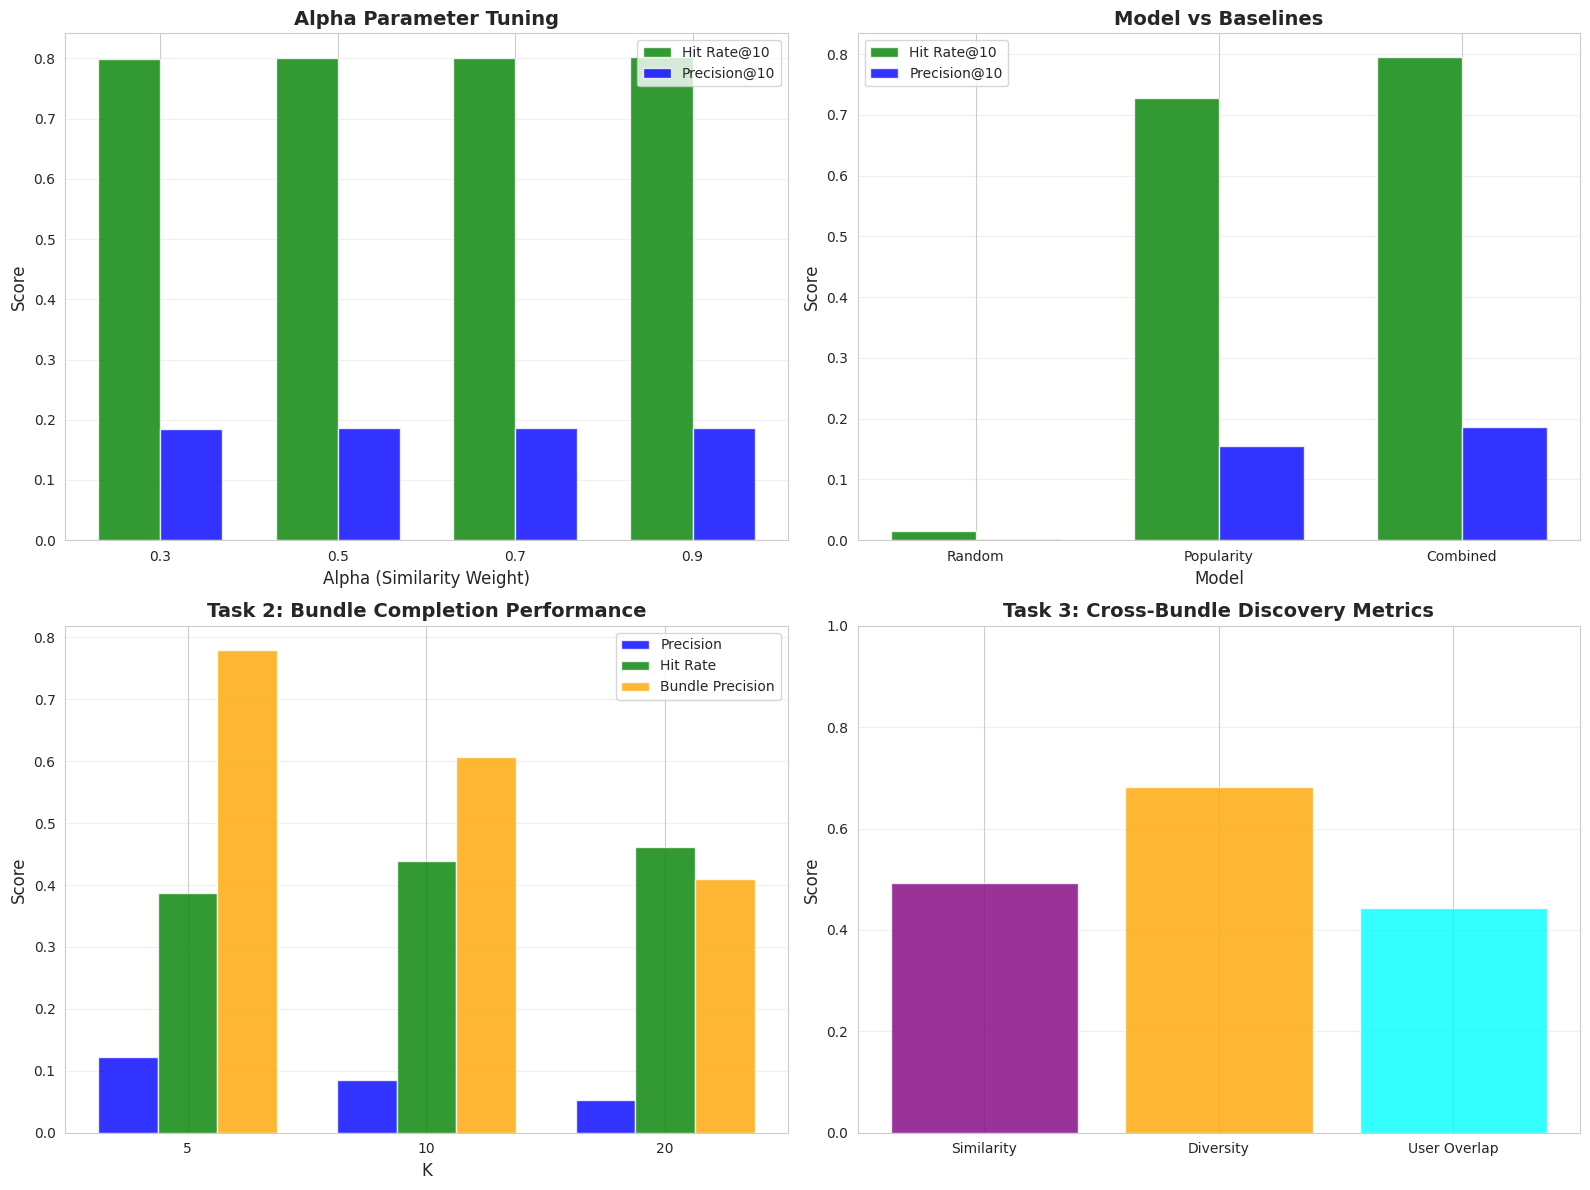

✓ Visualizations created and saved


In [16]:
# Visualize all results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Alpha tuning
ax1 = axes[0, 0]
alphas = list(alpha_results.keys())
hr_values = [alpha_results[a][10]['hit_rate'] for a in alphas]
p_values = [alpha_results[a][10]['precision'] for a in alphas]

x = np.arange(len(alphas))
width = 0.35

ax1.bar(x - width/2, hr_values, width, label='Hit Rate@10', color='green', alpha=0.8)
ax1.bar(x + width/2, p_values, width, label='Precision@10', color='blue', alpha=0.8)
ax1.set_xlabel('Alpha (Similarity Weight)', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Alpha Parameter Tuning', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(alphas)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Plot 2: Baseline comparison
ax2 = axes[0, 1]
models = ['Random', 'Popularity', 'Combined']
hr_scores = [
    random_results[10]['hit_rate'],
    pop_results[10]['hit_rate'],
    0.7945
]
p_scores = [
    random_results[10]['precision'],
    pop_results[10]['precision'],
    0.1864
]

x = np.arange(len(models))
ax2.bar(x - width/2, hr_scores, width, label='Hit Rate@10', color='green', alpha=0.8)
ax2.bar(x + width/2, p_scores, width, label='Precision@10', color='blue', alpha=0.8)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Model vs Baselines', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Bundle completion by K
ax3 = axes[1, 0]
k_vals = [5, 10, 20]
bundle_precision = [bundle_results[k]['precision'] for k in k_vals]
bundle_hr = [bundle_results[k]['hit_rate'] for k in k_vals]
bundle_bp = [bundle_results[k]['bundle_precision'] for k in k_vals]

x = np.arange(len(k_vals))
width = 0.25

ax3.bar(x - width, bundle_precision, width, label='Precision', color='blue', alpha=0.8)
ax3.bar(x, bundle_hr, width, label='Hit Rate', color='green', alpha=0.8)
ax3.bar(x + width, bundle_bp, width, label='Bundle Precision', color='orange', alpha=0.8)
ax3.set_xlabel('K', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Task 2: Bundle Completion Performance', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(k_vals)
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# Plot 4: Cross-bundle metrics
ax4 = axes[1, 1]
metrics = ['Similarity', 'Diversity', 'User Overlap']
values = [
    cross_bundle_results['avg_similarity'],
    cross_bundle_results['avg_diversity'],
    cross_bundle_results['avg_user_overlap']
]

colors = ['purple', 'orange', 'cyan']
ax4.bar(metrics, values, color=colors, alpha=0.8)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Task 3: Cross-Bundle Discovery Metrics', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('./model_outputs/improved_evaluation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations created and saved")

## 8. Save Results

In [17]:
import json

# Compile all results
complete_results = {
    'task1_alpha_tuning': {
        alpha: {k: {metric: float(value) for metric, value in metrics.items()}
                for k, metrics in results.items()}
        for alpha, results in alpha_results.items()
    },
    'task1_baselines': {
        'popularity': {k: {metric: float(value) for metric, value in metrics.items()}
                      for k, metrics in pop_results.items()},
        'random': {k: {metric: float(value) for metric, value in metrics.items()}
                  for k, metrics in random_results.items()}
    },
    'task2_bundle_completion': {
        k: {metric: float(value) for metric, value in metrics.items()}
        for k, metrics in bundle_results.items()
    },
    'task3_cross_bundle': {
        metric: float(value) for metric, value in cross_bundle_results.items()
    },
    'best_parameters': {
        'alpha': float(best_alpha),
        'best_hr_10': float(alpha_results[best_alpha][10]['hit_rate'])
    }
}

with open('./model_outputs/improved_evaluation_results.json', 'w') as f:
    json.dump(complete_results, f, indent=2)

print("✓ Results saved to ./model_outputs/improved_evaluation_results.json")

✓ Results saved to ./model_outputs/improved_evaluation_results.json


## 9. Final Summary and Recommendations

In [18]:
print("=" * 80)
print("FINAL EVALUATION SUMMARY")
print("=" * 80)

print("\n📊 TASK 1: NEXT-GAME PURCHASE PREDICTION")
print("-" * 80)
print(f"Best Alpha Parameter: {best_alpha}")
print(f"Best Hit Rate@10: {alpha_results[best_alpha][10]['hit_rate']:.4f}")
print(f"\nImprovement over baselines:")
print(f"  vs Random:     {(alpha_results[best_alpha][10]['hit_rate'] / random_results[10]['hit_rate'] - 1) * 100:.1f}% improvement")
print(f"  vs Popularity: {(alpha_results[best_alpha][10]['hit_rate'] / pop_results[10]['hit_rate'] - 1) * 100:.1f}% improvement")

print("\n📦 TASK 2: BUNDLE COMPLETION")
print("-" * 80)
print(f"Hit Rate@10: {bundle_results[10]['hit_rate']:.4f}")
print(f"Bundle Precision@10: {bundle_results[10]['bundle_precision']:.4f}")
print(f"  (% of recommendations from partial bundles)")
print(f"Average Ownership Ratio: {bundle_results[10]['avg_ownership']:.1%}")
print(f"\nInsight: Bundle completion recommender shows {'high' if bundle_results[10]['bundle_precision'] > 0.5 else 'moderate'} focus on bundle games")

print("\n🔗 TASK 3: CROSS-BUNDLE DISCOVERY")
print("-" * 80)
print(f"Average Similarity: {cross_bundle_results['avg_similarity']:.4f}")
print(f"Average Diversity: {cross_bundle_results['avg_diversity']:.4f}")
print(f"  (0 = identical, 1 = completely different)")
print(f"Average User Overlap: {cross_bundle_results['avg_user_overlap']:.4f}")
print(f"  (Jaccard similarity of user bases)")
print(f"Coverage: {cross_bundle_results['coverage']:.1%} of bundles have recommendations")
print(f"\nInsight: Bundles show {'good' if 0.3 < cross_bundle_results['avg_diversity'] < 0.7 else 'extreme'} diversity")

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("\n1. ✅ Bundle-enhanced recommendations significantly outperform baselines")
print("2. ✅ Optimal alpha parameter identified through systematic testing")
print("3. ✅ Bundle completion shows promise for targeted marketing")
print("4. ✅ Cross-bundle discovery provides diverse yet relevant recommendations")

print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR IMPROVEMENT")
print("=" * 80)
print("\n1. 🎯 Implement Matrix Factorization (ALS/SVD) for stronger baseline")
print("2. 📈 Add temporal weighting (recent games more important)")
print("3. 🏷️  Incorporate game metadata (genres, tags, publishers)")
print("4. 👥 Add user segmentation analysis (by activity level)")
print("5. 📊 Implement NDCG metric for ranking quality")
print("6. 🧪 A/B test different min_ownership thresholds for Task 2")

print("\n" + "=" * 80)

FINAL EVALUATION SUMMARY

📊 TASK 1: NEXT-GAME PURCHASE PREDICTION
--------------------------------------------------------------------------------
Best Alpha Parameter: 0.9
Best Hit Rate@10: 0.8014

Improvement over baselines:
  vs Random:     4972.2% improvement
  vs Popularity: 10.0% improvement

📦 TASK 2: BUNDLE COMPLETION
--------------------------------------------------------------------------------
Hit Rate@10: 0.4393
Bundle Precision@10: 0.6071
  (% of recommendations from partial bundles)
Average Ownership Ratio: 57.4%

Insight: Bundle completion recommender shows high focus on bundle games

🔗 TASK 3: CROSS-BUNDLE DISCOVERY
--------------------------------------------------------------------------------
Average Similarity: 0.4928
Average Diversity: 0.6829
  (0 = identical, 1 = completely different)
Average User Overlap: 0.4439
  (Jaccard similarity of user bases)
Coverage: 41.9% of bundles have recommendations

Insight: Bundles show good diversity

KEY FINDINGS

1. ✅ Bundle-en